# <center>Active learning</center>

## Introduction

This notebook aims to explore the effectiveness of active learning in improving machine learning performance when faced with a limited amount of labeled data and a large pool of unlabeled data. The traditional machine learning approach typically requires a substantial amount of labeled data to achieve satisfactory results. However, in many real-world scenarios, acquiring labeled data can be expensive, time-consuming, or impractical.

## Active learning techinque

Active learning offers a solution to this problem by intelligently selecting the most informative and uncertain samples from the unlabeled pool and adding them to the labeled set for training. By iteratively repeating this process, we can progressively improve the learning algorithm's performance without the need for large amounts of labeled data.

**In our case, as we are dealing with a regression problem, we define the uncertain samples as those that have a longer distance from the mean of the predictions**. This measure of uncertainty allows us to prioritize the samples that the model finds most challenging to accurately predict. By incorporating these uncertain samples into the labeled set, we aim to improve the model's understanding of complex patterns and enhance its ability to generalize.

## Comparison with Random Sampling

 In this notebook, we will compare the active learning technique with a random sampling approach. The active learning technique involves selecting the most uncertain samples from the unlabeled pool based on some measure of uncertainty, such as entropy or margin. We will add these uncertain samples to the labeled set and retrain the machine learning algorithm. By doing so, we can evaluate the impact of incorporating these informative samples on the overall performance of the model.

## Objective 

 The objective of this notebook is to analyze and demonstrate how active learning can significantly enhance the learning process when faced with data scarcity. By comparing the performance of the active learning technique with random sampling, we aim to highlight the advantages and potential gains achieved through active learning. Through a series of experiments and evaluations, we will assess the impact of active learning on the overall model performance and showcase its potential as a powerful tool for efficient and effective machine learning with limited labeled data.

### Library imports & system configurations

In [17]:
import pandas as pd
import numpy as np

# %matplotlib inline
# import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tqdm.notebook import tqdm

seed = 13
np.random.seed(seed)

### Data loading

In [18]:
diabetes_data = load_diabetes()
X, y = diabetes_data['data'], diabetes_data['target']
print("X shape: ", X.shape, "y shape: ", y.shape)

X shape:  (442, 10) y shape:  (442,)


### Data exploration

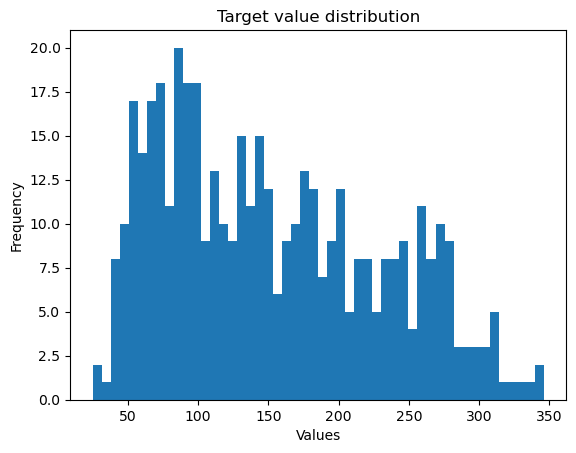

In [19]:
plt.hist(y, bins=50)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Target value distribution')
plt.show()

### Split data

In [20]:
def split_labeled_unlabeled(X, y, labeled_samples_percent=0.5):
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, train_size=labeled_samples_percent,
                                                                      random_state=seed)
    return X_labeled, X_unlabeled, y_labeled, y_unlabeled

In [21]:
labeled_samples_percent = 0.5
X_labeled, X_unlabeled, y_labeled, y_unlabeled = split_labeled_unlabeled(X, y,
                                                                         labeled_samples_percent=labeled_samples_percent)
print("X labeled shape: ", X_labeled.shape)
print("X_unlabeled shape: ", X_unlabeled.shape)

X labeled shape:  (221, 10)
X_unlabeled shape:  (221, 10)


### Preprocessing - scaling

In [22]:
def scale_data(X_labeled, X_unlabeled):
    ss_scaler = StandardScaler()
    X_labeled = ss_scaler.fit_transform(X_labeled)
    X_unlabeled = ss_scaler.transform(X_unlabeled)
    return X_labeled, X_unlabeled

In [23]:
X_labeled, X_unlabeled = scale_data(X_labeled, X_unlabeled)

### Techniques
#### Active learning vs Random sampling

In [24]:
def plot_mse_scores_over_iterations(active_mse_scores, random_mse_scores):
    iterations = range(1, len(active_mse_scores) + 1)

    plt.plot(iterations, active_mse_scores, marker='o', label='Active Learning')
    plt.plot(iterations, random_mse_scores, marker='o', label='Random Sampling')

    plt.xlabel('Iterations')
    plt.ylabel('MSE Score')
    plt.title('MSE Scores over Iterations')
    plt.legend()
    plt.show()
    

def compare_mse_scores(active_learning_mse, random_sampling_mse):
    methods = ['Active Learning', 'Random Sampling']
    mse_scores = [active_learning_mse, random_sampling_mse]

    x_pos = np.arange(len(methods))

    plt.bar(x_pos, mse_scores, align='center', alpha=0.5)
    plt.xticks(x_pos, methods)
    plt.ylabel('MSE Score')
    plt.title('Comparison of MSE Scores')

    plt.show()

def apply_active_learning(regr_name, regressor, X_labeled, y_labeled, X_unlabeled, y_unlabeled, num_of_iter=10,
                          labeled_samples_per_iter=5):

    active_mse_results = []
    applied_method = 'Active learning'
    
    for i in tqdm(range(num_iterations), desc=f"Active learning with {regr_name}..."):
        print("Iteration", i+1)

        regressor.fit(X_labeled, y_labeled)
        y_pred_unlabeled = regressor.predict(X_unlabeled)

        # Calculate the uncertainty scores for each unlabeled sample
        uncertainty_scores = np.abs(y_pred_unlabeled - np.mean(y_pred_unlabeled))
        selected_indices = np.argsort(uncertainty_scores)[-labeled_samples_per_iter:]

        X_labeled = np.concatenate([X_labeled, X_unlabeled[selected_indices]])
        y_labeled = np.concatenate([y_labeled, y_unlabeled[selected_indices]])

        X_unlabeled = np.delete(X_unlabeled, selected_indices, axis=0)
        y_unlabeled = np.delete(y_unlabeled, selected_indices)

        y_pred_labeled = regressor.predict(X_labeled)
        mse = mean_squared_error(y_labeled, y_pred_labeled)
        active_mse_results.append(mse)
        print("MSE on labeled set:", mse)
        print()

    # Final evaluation on the test set
    print("Remain unlabeled as test set: ", len(X_unlabeled))
    y_pred_test = regressor.predict(X_unlabeled)
    mse_test = mean_squared_error(y_unlabeled, y_pred_test)
    print("Final MSE on test set:", mse_test)
    return mse_test, active_mse_results

def apply_random_selection(regr_name, regressor, X_labeled, y_labeled, X_unlabeled, y_unlabeled, num_of_iter=10,
                          labeled_samples_per_iter=5):

    random_mse_results = []
    applied_method = 'Random selection'
    
    for i in tqdm(range(num_iterations), desc=f"Random selection with {regr_name}..."):
        print("Iteration", i+1)
        
        regressor.fit(X_labeled, y_labeled)

        # Select random indexes
        random_indexes = np.random.choice(len(X_unlabeled), size=labeled_samples_per_iter, replace=False)


        X_labeled = np.concatenate([X_labeled, X_unlabeled[random_indexes]])
        y_labeled = np.concatenate([y_labeled, y_unlabeled[random_indexes]])

        X_unlabeled = np.delete(X_unlabeled, random_indexes, axis=0)
        y_unlabeled = np.delete(y_unlabeled, random_indexes)

        y_pred_labeled = regressor.predict(X_labeled)
        mse = mean_squared_error(y_labeled, y_pred_labeled)
        random_mse_results.append(mse)
        print("MSE on labeled set:", mse)
        print()

    # Final evaluation on the test set
    print("Remain unlabeled as test set: ", len(X_unlabeled))
    y_pred_test = regressor.predict(X_unlabeled)
    mse_test = mean_squared_error(y_unlabeled, y_pred_test)
    print("Final MSE on test set:", mse_test)
    return mse_test, random_mse_results

In [25]:
regressor_1 = SVR()
regressor_2 = SVR()
num_iterations = 10
num_of_samples_per_iter = 10

In [26]:
active_test_mse, active_mse_results = apply_active_learning(type(regressor_1).__name__, regressor_1,X_labeled,
                                                      y_labeled, X_unlabeled, y_unlabeled, num_of_iter=num_iterations,
                                                      labeled_samples_per_iter=num_of_samples_per_iter)


Active learning with SVR...:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration 1
MSE on labeled set: 5403.764313388733

Iteration 2
MSE on labeled set: 5330.833250229956

Iteration 3
MSE on labeled set: 5316.178839796981

Iteration 4
MSE on labeled set: 5256.979073938754

Iteration 5
MSE on labeled set: 5179.7293482198575

Iteration 6
MSE on labeled set: 5006.939918948081

Iteration 7
MSE on labeled set: 5025.622431998356

Iteration 8
MSE on labeled set: 5013.487302723996

Iteration 9
MSE on labeled set: 4881.044231394451

Iteration 10
MSE on labeled set: 4917.042857533098

Remain unlabeled as test set:  121
Final MSE on test set: 3745.772858655682


In [27]:
random_test_mse, random_mse_results = apply_random_selection(type(regressor_2).__name__, regressor_2,X_labeled,
                                                      y_labeled, X_unlabeled, y_unlabeled, num_of_iter=num_iterations,
                                                      labeled_samples_per_iter=num_of_samples_per_iter)

Random selection with SVR...:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration 1
MSE on labeled set: 5551.612339032242

Iteration 2
MSE on labeled set: 5503.457684687449

Iteration 3
MSE on labeled set: 5410.641232874521

Iteration 4
MSE on labeled set: 5324.684784223472

Iteration 5
MSE on labeled set: 5224.625978141554

Iteration 6
MSE on labeled set: 5181.872380535289

Iteration 7
MSE on labeled set: 5135.566077602125

Iteration 8
MSE on labeled set: 5014.2016489858615

Iteration 9
MSE on labeled set: 5077.401146978103

Iteration 10
MSE on labeled set: 4970.810823479506

Remain unlabeled as test set:  121
Final MSE on test set: 4287.806010601133


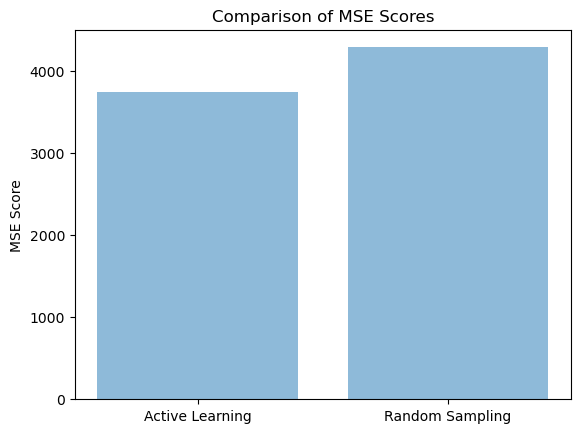

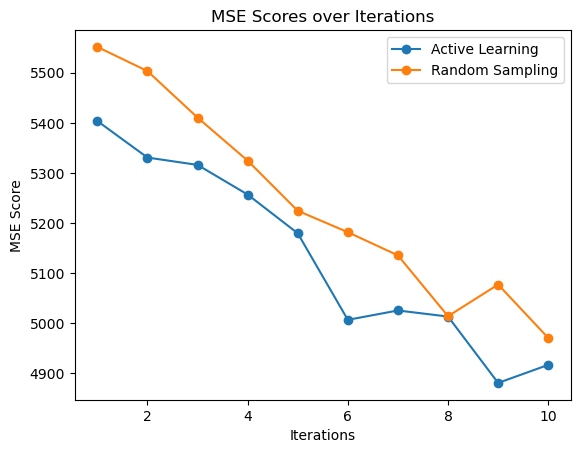

In [28]:
compare_mse_scores(active_learning_mse=active_test_mse, random_sampling_mse=random_test_mse)
plot_mse_scores_over_iterations(active_mse_scores=active_mse_results, random_mse_scores=random_mse_results)

In [29]:
print("Active learning test mse: ", round(active_test_mse, 2), "\nRandom sampling test mse: ", round(random_test_mse, 2))

Active learning test mse:  3745.77 
Random sampling test mse:  4287.81


### Comparative Analysis of Active Learning and Random Sampling Techniques

Upon analyzing the results of the experiments comparing active learning and random sampling, we observed the following test mean squared error (MSE) values:

- Active learning test MSE: 3745.77 
- Random sampling test MSE: 4287.81

The MSE values provide an indication of the model's accuracy in predicting the target variable. A lower MSE indicates a better fit to the data. Comparing the test MSEs, we can observe that the active learning approach resulted in a lower MSE compared to random sampling. This suggests that active learning was able to effectively leverage the uncertain samples and improve the model's predictive performance.

Furthermore, we examined the MSE scores over iterations of adding uncertain samples for active learning and random samples for random sampling.
Analyzing the MSE scores over iterations, we can observe that both active learning and random sampling experienced a decrease in MSE as more samples were added to the labeled set. However, the MSE values for active learning consistently remained lower than those for random sampling. This suggests that active learning's strategy of selecting uncertain samples for labeling resulted in better model refinement and improved prediction accuracy compared to random sampling.

Overall, these results highlight the effectiveness of active learning in leveraging uncertain samples and enhancing the learning process. By iteratively selecting and incorporating informative samples, active learning achieved lower test MSE and demonstrated its potential as a powerful technique for improving model performance with limited labeled data.